In [4]:
import glob
import os
import time
import csv

# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
# os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
import h5py
# import imageio
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils
import torchvision.models.resnet as resnet

# from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset

In [6]:
class ResNet(resnet.ResNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self._forward_impl(x))

In [5]:
def load_data(size):
    # data size = 96
    hfs = 48 # half full size 96/2=48
    hs = size//2
    start = hfs-hs
    end = hfs+hs
    
    X = np.load('X_clean.npy')[:, start:end, start:end]/255
    X = np.moveaxis(X, -1, 1).astype(np.float32)
    y = np.load('Y_clean.npy').reshape(-1,1).astype(np.float32)
    wsi = np.load('WSI_clean.npy')
    
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
#     X_0 = torch.from_numpy(X[WSI==0])
#     X_1 = torch.from_numpy(X[WSI==1])
#     Y_0 = torch.from_numpy(Y[WSI==0])
#     Y_1 = torch.from_numpy(Y[WSI==1])
#     return X_0, Y_0, X_1, Y_1

    return X, y, wsi

In [7]:
X, y, wsi = load_data(48)

X0 = X[wsi==0]
y0 = y[wsi==0]
X1 = X[wsi==1]
y1 = y[wsi==1]

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=0)
X0_train, X0_val, y0_train, y0_val = train_test_split(X0_train, y0_train, test_size=0.25, random_state=0)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.25, random_state=0)

In [9]:
X, y, wsi = load_data(48)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

trainloader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valloader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
# plt.hist(y_train_small.numpy(), bins=2)

TypeError: take(): argument 'index' (position 1) must be Tensor, not numpy.ndarray

In [11]:
X_train = np.concatenate([np.load('X0_train_clean_48.npy'), np.load('X1_train_clean_48.npy')])
X_val = np.concatenate([np.load('X0_val_clean_48.npy'),  np.load('X1_val_clean_48.npy')])
y_train = np.concatenate([np.load('y0_train_clean_48.npy'), np.load('y1_train_clean_48.npy')])
y_val = np.concatenate([np.load('y0_val_clean_48.npy'), np.load('y1_val_clean_48.npy')])

X_train = torch.from_numpy(X_train)
X_val =  torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

trainloader = DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True, num_workers=1, pin_memory=True)
valloader = DataLoader(TensorDataset(X_val, y_val), batch_size=256, shuffle=True, num_workers=1, pin_memory=True)


# X_test = np.load('X0_test_clean_48.npy')
# y_test = np.load('y0_test_clean_48.npy')


# X_train = np.load('X1_train_clean_48.npy')
# X_test = np.load('X1_test_clean_48.npy')
# X_val = np.load('X1_val_clean_48.npy')
# y_train = np.load('y1_train_clean_48.npy')
# y_test = np.load('y1_test_clean_48.npy')
# y_val = np.load('y1_val_clean_48.npy')

In [12]:
X_train.shape

torch.Size([192982, 3, 48, 48])

In [9]:
@torch.no_grad()
def eval_Clf(model, validation_loader):
    model.eval()        
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0].cuda()
        y = data[1].cuda()
#             predicted = torch.argmax(model(X), dim=1)
        predicted = torch.round(model(X))
        acc+=(predicted == y).sum()/float(predicted.shape[0])       
    model.train()
    return (acc/(i+1)).detach().item()

In [10]:
class Training:
    def __init__(self, model, model_name, cuda_device='cuda:0', lr=1e-4, early_stopping_count=20):
        self.model_name = model_name
        self.early_stopping_count = early_stopping_count
        
        device = 'cpu'
        if torch.cuda.is_available():
            device = cuda_device
        self.device = torch.device(device)
        
        self.Clf = model.to(self.device)

        self.Clf_opt = optim.Adam(self.Clf.parameters(), lr=lr)
        self.Clf_criterion = torch.nn.BCELoss()
        
        self.path = 'results/'+model_name
        
        self.best_acc = .0
        self.best_acc_count = 0

        if not os.path.exists(self.path):
            os.mkdir(self.path)

    def train(self, train_loader, validation_loader, epochs):

        self.stats = {
            'clf_loss': [],
            'clf_acc': [],
            'clf_loss_val': [],
            'clf_acc_val': [],
            
        }

        for epoch in range(epochs):
            clf_loss = []
            clf_acc = []

            for i, data in enumerate(train_loader):
                X = data[0].to(self.device)
                y = data[1].to(self.device)
                    
                loss, acc = self._train_Clf(X, y)
                clf_loss.append(loss)
                clf_acc.append(acc)                                
            
#             if epoch % 10 == 0:
            acc_val = eval_Clf(self.Clf, validation_loader)
            clf_loss_m = sum(clf_loss)/len(clf_loss)
            clf_acc_m = sum(clf_acc)/len(clf_acc)     
            self.stats['clf_loss'].append(clf_loss_m)
            self.stats['clf_acc'].append(clf_acc_m)
#             self.stats['clf_loss_val'].append(loss_val)
            self.stats['clf_acc_val'].append(acc_val)

            self.best_acc_count+=1
            if acc_val > self.best_acc:
                self.best_acc = acc_val
                self.best_acc_count = 0
                self.save_best()
    
            print("Epoch: %d, loss: %f, acc: %.3f, acc_val: %.3f"%(epoch, clf_loss_m, clf_acc_m, acc_val))
            
            if self.best_acc_count >= self.early_stopping_count:
                break
        print("Finished. Best acc: %.3f"%(self.best_acc))

#     def _eval_Clf(self, validation_loader):
#         self.Clf.eval()        
#         with torch.no_grad():
#             acc = .0
#             for i, data in enumerate(validation_loader):
#                 X = data[0].to(self.device)
#                 y = data[1].to(self.device)

#                 predicted = torch.argmax(self.Clf(X), dim=1)
#                 acc+=(predicted == y).sum()/float(predicted.shape[0])       
#         self.Clf.train()
#         return (acc/(i+1)).detach().item()

    def _train_Clf(self, data, labels):
        self.Clf_opt.zero_grad()
        
        predicted = self.Clf(data)
    
        loss = self.Clf_criterion(predicted, labels)
        
        loss.backward()
        self.Clf_opt.step()    
      
        acc = (np.round(predicted.detach().cpu()) == labels.detach().cpu()).sum()/float(predicted.shape[0])
#         acc = (torch.argmax(predicted.detach().cpu(), dim=1) == labels.detach().cpu()).sum()/float(predicted.shape[0])

        return loss.detach().item(), acc.item()

    def save_best(self):
        torch.save(self.Clf.state_dict(), self.path+'/best_model.pth')
        np.save(self.path+'/acc_val.npy', t.stats['clf_acc_val'], allow_pickle=False)
        np.save(self.path+'/acc.npy', t.stats['clf_acc'], allow_pickle=False)
        np.save(self.path+'/loss.npy', t.stats['clf_loss'], allow_pickle=False)


In [14]:
t = Training(ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1), 'clf_resnet18_32', early_stopping_count=50)
t.train(trainloader, valloader, 100)

Epoch: 0, loss: 0.479146, acc: 0.774, acc_val: 0.785
Epoch: 1, loss: 0.430232, acc: 0.805, acc_val: 0.793
Epoch: 2, loss: 0.392504, acc: 0.827, acc_val: 0.809
Epoch: 3, loss: 0.346956, acc: 0.851, acc_val: 0.811
Epoch: 4, loss: 0.295020, acc: 0.876, acc_val: 0.810
Epoch: 5, loss: 0.239303, acc: 0.903, acc_val: 0.820
Epoch: 6, loss: 0.190317, acc: 0.924, acc_val: 0.813
Epoch: 7, loss: 0.148706, acc: 0.942, acc_val: 0.817
Epoch: 8, loss: 0.123299, acc: 0.953, acc_val: 0.803
Epoch: 9, loss: 0.105706, acc: 0.959, acc_val: 0.813
Epoch: 10, loss: 0.094047, acc: 0.964, acc_val: 0.803
Epoch: 11, loss: 0.084715, acc: 0.968, acc_val: 0.802
Epoch: 12, loss: 0.077040, acc: 0.971, acc_val: 0.809
Epoch: 13, loss: 0.074693, acc: 0.972, acc_val: 0.814
Epoch: 14, loss: 0.068382, acc: 0.975, acc_val: 0.812
Epoch: 15, loss: 0.067117, acc: 0.975, acc_val: 0.813
Epoch: 16, loss: 0.061643, acc: 0.977, acc_val: 0.822
Epoch: 17, loss: 0.060319, acc: 0.978, acc_val: 0.811
Epoch: 18, loss: 0.057798, acc: 0.979,

In [13]:
X0_test = np.load('X0_test_clean_48.npy')
y0_test = np.load('y0_test_clean_48.npy')

X1_test = np.load('X1_test_clean_48.npy')
y1_test = np.load('y1_test_clean_48.npy')

X_test = np.concatenate([X0_test, X1_test])
y_test = np.concatenate([y0_test, y1_test])

X0_test = torch.from_numpy(X0_test)
y0_test = torch.from_numpy(y0_test)
X1_test = torch.from_numpy(X1_test)
y1_test = torch.from_numpy(y1_test)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)


testloader0 = DataLoader(TensorDataset(X0_test, y0_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
testloader1 = DataLoader(TensorDataset(X1_test, y1_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

In [17]:
model = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
model.load_state_dict(torch.load('results/clf_resnet18_48/best_model.pth'))
model.cuda()

eval_Clf(model, testloader0), eval_Clf(model, testloader1), eval_Clf(model, testloader)

(0.8511611819267273, 0.8814132213592529, 0.8634864091873169)

In [17]:
from torchsummary import summary

summary(ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1).cuda(), (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [9]:
import hiddenlayer as hl

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


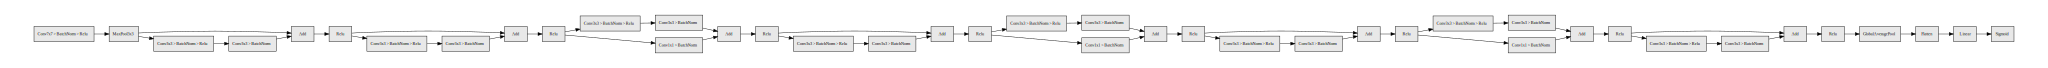

In [11]:
model = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
hl.build_graph(model, torch.ones((1,3,48,48)))